# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Add path .. to make relative import

In [2]:
import sys

sys.path.insert(0, '..')

# Import libraries

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams

from src.preparation.reading import *
from src.processing.standardization import standardize_image
from skimage.morphology import disk
from skimage.filters.rank import enhance_contrast_percentile, otsu
from skimage.morphology import disk

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

# Coherence filter

## Read image

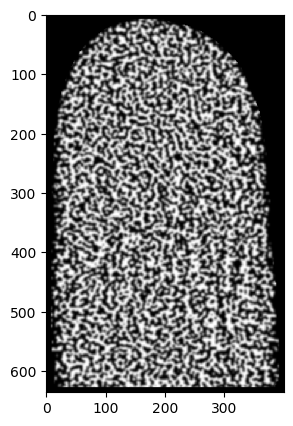

In [4]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)

plt.imshow(std_im)
pass

# Coherence function filter

In [5]:
def get_second_derivative(im, ksize=3):
    gxx = cv.Sobel(im, cv.CV_64F, 2, 0, ksize=ksize)
    gxy = cv.Sobel(im, cv.CV_64F, 1, 1, ksize=ksize)
    gyy = cv.Sobel(im, cv.CV_64F, 0, 2, ksize=ksize)
    
    return gxx, gxy, gyy

In [6]:
def coherence_filter(im, sigma = 15, str_sigma = 15, blend = 0.5, n_iter = 5):
    
    h, w = im.shape[:2]

    for i in range(n_iter):
        eigen = cv.cornerEigenValsAndVecs(im, str_sigma, 3)
        eigen = eigen.reshape(h, w, 3, 2)  # [[e1, e2], v1, v2]
        
        x, y = eigen[:,:,1,0], eigen[:,:,1,1]

        gxx, gxy, gyy = get_second_derivative(im, sigma)
        gvv = x*x*gxx + 2*x*y*gxy + y*y*gyy
        
        m = gvv < 0

        ero = cv.erode(im, None)
        dil = cv.dilate(im, None)
        im1 = ero
        im1[m] = dil[m]
        im = np.uint8(im*(1.0 - blend) + im1*blend)

    return im

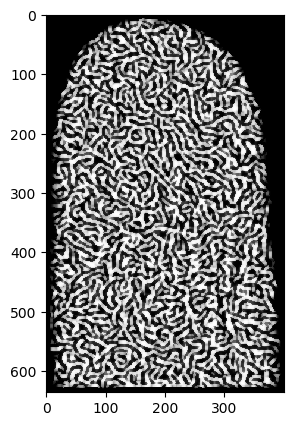

In [7]:
coh_image = coherence_filter(std_im, sigma=15, str_sigma=15, n_iter=3) 

plt.imshow(coh_image);

# Image Preprocessing

## Read image 

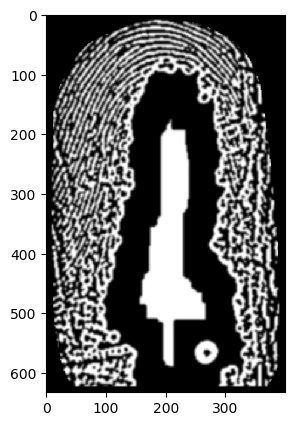

In [8]:
im = read_random_image(RAW_FILE_PATH_BADIM_HOLES)
std_im = standardize_image(im)

plt.imshow(std_im)
pass

## Gaussian blur

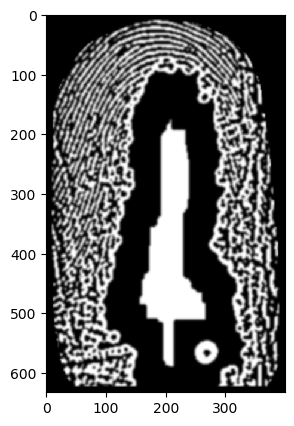

In [9]:
gaus_im = cv.GaussianBlur(std_im, (3, 3), -1)

plt.imshow(gaus_im)
plt.show()

## Histogramm equlization

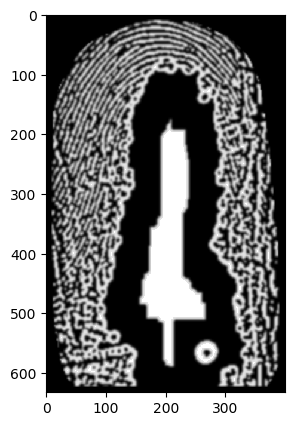

In [10]:
eqhist_im = cv.equalizeHist(gaus_im)

plt.imshow(eqhist_im)
pass

## Coherence filter

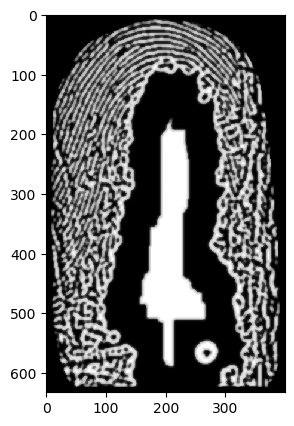

In [11]:
coh_im = coherence_filter(eqhist_im, n_iter=1)

plt.imshow(coh_im)
plt.show()

## Threshold

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


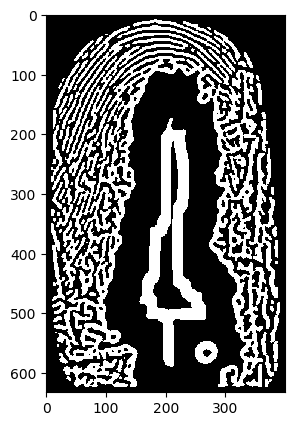

In [12]:
%time
thresh_otsu = cv.threshold(coh_im, coh_im.mean(), 255, cv.THRESH_BINARY)[1]
thresh_adap = cv.adaptiveThreshold(coh_im, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 31, 0)


plt.imshow(thresh_adap)
plt.show()

## Make preprocessing image

In [13]:
def preproc_image(im, ksize=3, n_iter=1, blend=0.5):
    gaus_im = cv.GaussianBlur(im, (ksize,)*2, -1)
    eqhist_im = cv.equalizeHist(im)
    coh_im = coherence_filter(eqhist_im, n_iter=n_iter, blend=blend)
    #thresh = cv.threshold(coh_im, 0, 255, cv.THRESH_OTSU)[1]
    thresh = cv.adaptiveThreshold(coh_im, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 31, 0)
    
    return thresh

## Test Function

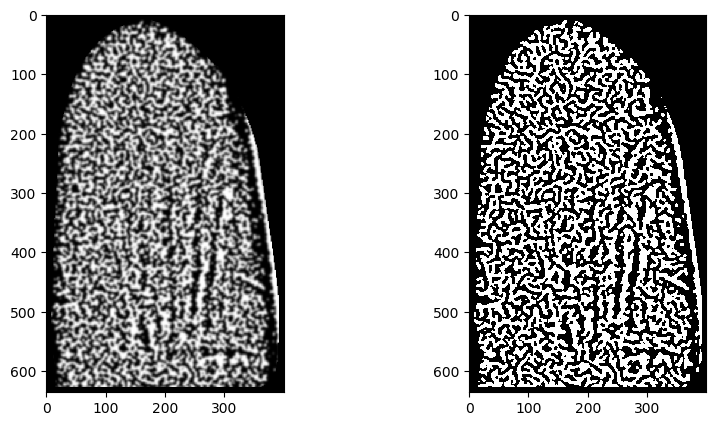

In [14]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(std_im)
ax2.imshow(prep_im)

plt.show()